In [1]:
import mamba_ssm
from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy
from nnsight.models.Mamba import MambaInterp
from transformers import AutoTokenizer
import numpy as np
import torch as t
import torch.nn.functional as F
import einops
from tqdm import tqdm
from functools import partial
from datasets import load_dataset
from torch.utils.data import DataLoader

from rich import print as rprint
from rich.table import Table

from typing import List, Callable, Union

device = t.device("cuda:2" if t.cuda.is_available() else "cpu")

/mnt/ssd-1/gpaulo/miniconda3/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [14]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b", padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
mamba_model = MambaInterp("state-spaces/mamba-2.8b", device=device, tokenizer=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
with mamba_model.invoke(steering_prompt,scan=True) as invoker:
        extracted_state_vectors=[]
        vectors = []
        for i in range(start,end):
            hidden_state = model.backbone.layers[i]
            vectors.append([hidden_state.output[0], hidden_state.output[1]])
            ssm_state = hidden_state.mixer.ssm.hx
            ssm_state = ssm_state.next(steering_prompt_len)
            vec = ssm_state.output
            extracted_state_vectors.append(vec)

In [2]:
dataset = load_dataset("JeanKaddour/minipile", data_dir="data")
val_dataset = dataset["validation"]
val_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=False)


Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Testrun

In [101]:
batch = val_dataset[5]
token_ids = tokenizer.encode(batch["text"], return_tensors="pt", padding=True, truncation=True, max_length=1024).to(device)

In [102]:
batch

{'text': 'Picking a favorite superhero is tough. But as of today thanks to good, not-so-old-fashioned Google Trends analytics, we know one thing for certain: Batman is the most popular superhero in the world – on YouTube at least.\n\nLogging more than 3 billion views of more than 71,000 hours of video, the Dark Knight is almost a billion views ahead of the next most popular hero—Thor—based on data released today by YouTube. Coming up close behind Thor is Superman, with 1.7 billion views and counting, and close behind the Man of Steel is Iron Man, the Avengers, and Wolverine. (Google’s analysis only looked at the specific name of each character, so nicknames like Man of Steel and Dark Knight weren’t counted in the totals.)\n\n“If YouTube popularity can determine who’ll win the upcoming Batman vs. Superman movie, your views and uploads put Batman as the clear winner,” the video-sharing site wrote on the YouTube Trends blog today. “Based on keyword searches, Batman is the most popular of 

In [103]:
with mamba_model.invoke(batch["text"],scan=True) as invoker:
    deltas = []
    for i in range(0,64):
        delta = mamba_model.backbone.layers[i].mixer.dt.output.save()
        deltas.append(delta)
    pass    
every_delta = t.cat([delta.value for delta in deltas], dim=0)
input_ids = tokenizer(batch["text"], return_tensors="pt").input_ids.to(device)    

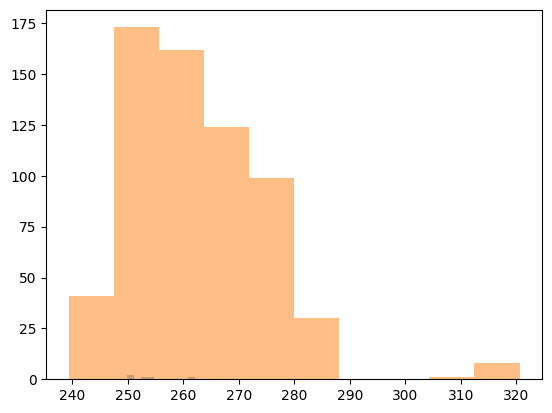

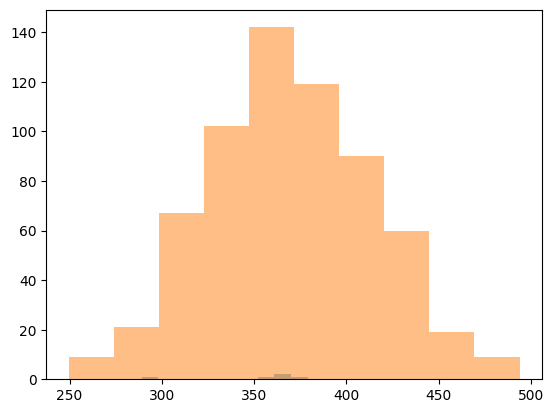

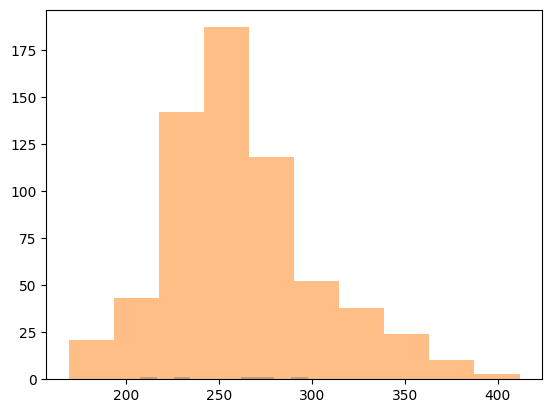

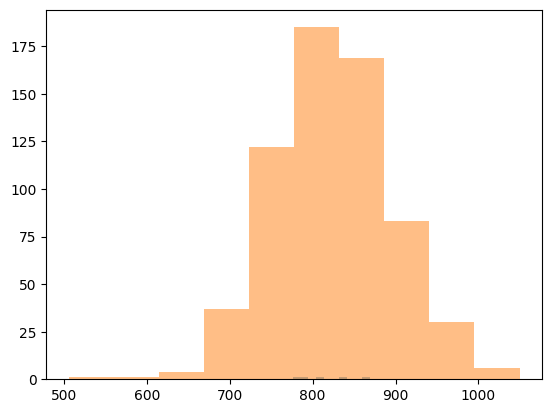

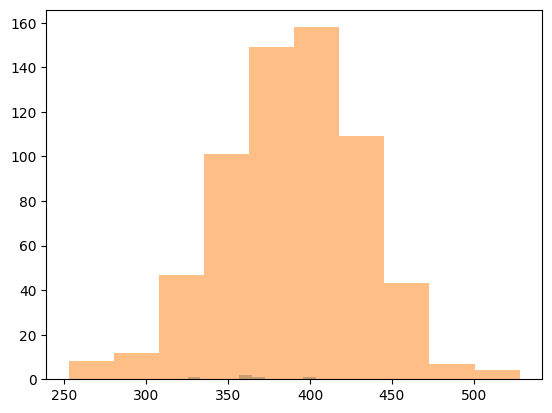

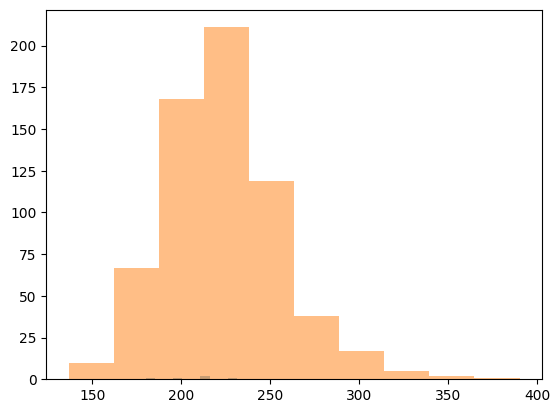

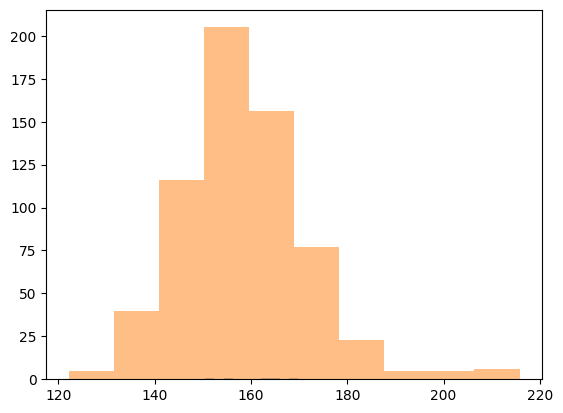

In [109]:
filler_tokens = ["\n \n   .,:-() . , : - ( ) \n\n ??"]
filler_target_ids = tokenizer(filler_tokens, return_tensors="pt").to(device).input_ids
filler_idx = t.arange(0, input_ids.size(1), device=device)[t.isin(input_ids,filler_target_ids)[0]]
non_filler_idx = t.arange(0, input_ids.size(1), device=device)[~t.isin(input_ids,filler_target_ids)[0]]


for layer in range(0,64,10):
    plt.figure()
    layer_delta = every_delta[layer]
    filler_magnitude = t.norm(layer_delta[:,filler_idx], dim=0)
    non_filler_magnitude = t.norm(layer_delta[:,non_filler_idx], dim=0)
    plt.hist(filler_magnitude.cpu().numpy(), bins=10, alpha=0.5, label=f"Filler")
    plt.hist(non_filler_magnitude.cpu().numpy(), bins=10, alpha=0.5, label=f"Non-filler")
    #print(f"Layer {layer} magnitude: {average_magnitude.item()} +- {std_magnitude.item()}")
    #average_magnitude = t.mean(magnitude)
    #std_magnitude = t.std(magnitude)


{'input_ids': tensor([[50276,   187,   783,   510,   253,   380]], device='cuda:2'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:2')}

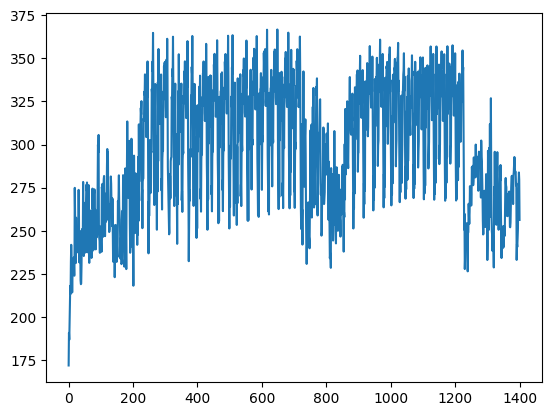

In [66]:
plt.plot(magnitude.cpu().numpy())

(0.0, 1000.0)

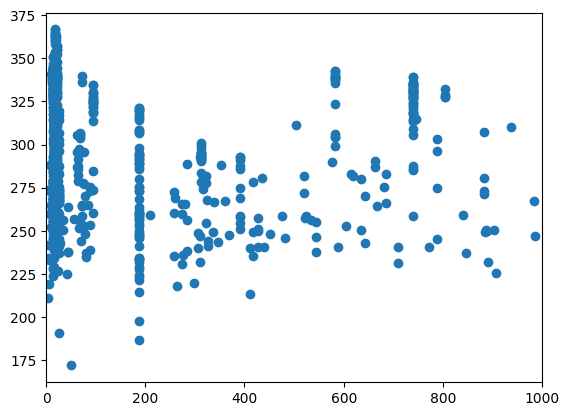

In [68]:
layer = 1
layer_delta = every_delta[layer]
num_tokens = 1000
slice_layer_delta = layer_delta
magnitude = t.norm(slice_layer_delta, dim=0)
plt.scatter(input_ids.cpu().numpy(),magnitude.cpu().numpy())
plt.xlim(0,1000)

In [36]:
from matplotlib import pyplot as plt

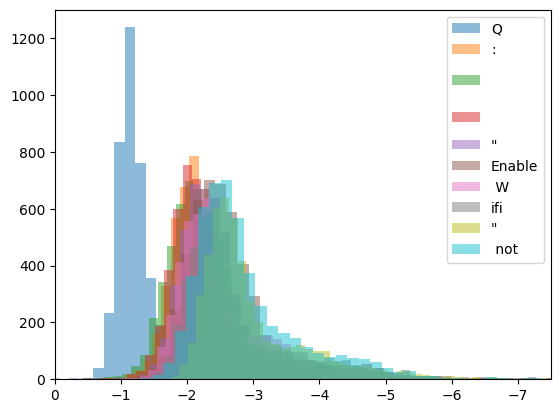

In [63]:
layer = 1
layer_delta = every_delta[layer]
num_tokens = 10
slice_layer_delta = layer_delta[:,:num_tokens]
for i in range(num_tokens):
    token = tokenizer.decode(input_ids[0,i].cpu().numpy())
    plt.hist(slice_layer_delta[:,i].cpu().numpy(), bins=100, alpha=0.5,label=token)
    plt.xlim(0,-7.5)
plt.legend()

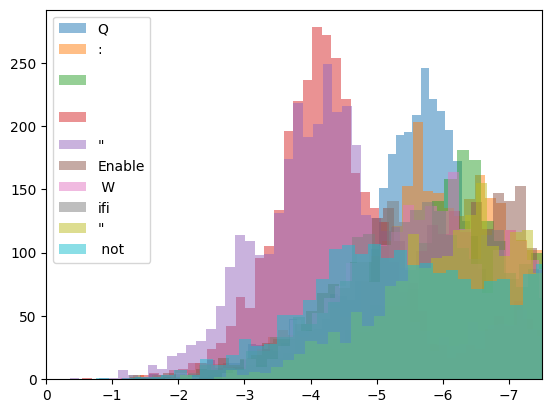

In [60]:
layer = 30
layer_delta = every_delta[layer]
num_tokens = 10
slice_layer_delta = layer_delta[:,:num_tokens]
for i in range(num_tokens):
    token = tokenizer.decode(input_ids[0,i].cpu().numpy())
    plt.hist(slice_layer_delta[:,i].cpu().numpy(), bins=100, alpha=0.5,label=token)
    plt.xlim(0,-7.5)
plt.legend()

In [65]:
tokenizer.decode(input_ids[0,:10])

'Q:\n\n"Enable Wifi" not'